In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from batch_plot import *
import seaborn as sns

/home/mila/s/stephen.lu/miniconda3/envs/gfn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def predict_assay_logits_from_smi(smis, assay_model, target_active_assay_cols):
    full_df = pd.DataFrame(smis, columns=["smiles"])
    dataset = TestDataset(full_df, mol_col="smiles", label_col=None)
    dataloader = make_eval_data_loader(dataset, batch_size=2048)
    y_hat = []
    for batch in tqdm(dataloader):
        y_hat.append(assay_model(batch)[0].detach().cpu().numpy())
    y_hat = np.vstack(y_hat)
    logit_values = y_hat[:, target_active_assay_cols.tolist()].squeeze()
    print(logit_values.shape)
    return logit_values

def predict_latents_from_smi(cfg, smis, n_samples=20000):
    mmc_model = load_mmc_model(cfg)
    random_idx = np.random.choice(len(smis), n_samples, replace=False)
    graphs = [mol2graph(Chem.MolFromSmiles(smi)) for smi in tqdm(smis[random_idx])]

    preds = []
    batch_size = 2048
    for i in range(0, len(graphs), batch_size):
        batch = gd.Batch.from_data_list([i for i in graphs[i:i+batch_size] if i is not None])
        batch.to(mmc_model.device if hasattr(mmc_model, 'device') else device)
        pred = mmc_model({"inputs": {"struct": batch}}, mod_name="struct")
        pred = pred.data.cpu().detach().numpy()
        preds.append(pred)

    return np.vstack(preds)

## Plot the correlation between gflownet reward and assay activity
We first choose a target sample, then retrieve all molecules sampled by gfn for that target along with the active assay columns under this target. We then compute the assay prediction logits for all sampled molecules and plot the correlation between the gflownet reward and the assay activity logit.

In [9]:
target_id = 903
run_id = "04-24-01-46-morph-sim-final-targets/snowy-sweep-3-id-in1e3736"

In [5]:
# Obtain representations and fingerprints for puma dataset
datamodule, cfg = setup_puma()
representations = get_representations()
dataset_fps = get_fingerprints(None)
dataset_smis = [x["inputs"]["struct"].mols for x in datamodule.dataset]
assay_dataset = load_assay_matrix_from_csv()
assay_model = load_assay_pred_model()

shuffled_scaffold


Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


Train on samples from shuffled_scaffold.
Train on 13582 samples.
Validate on 1698 samples.
Test on 1698 samples.


In [6]:
target_fp = dataset_fps[target_id]
target_smi = datamodule.dataset[target_id]["inputs"]["struct"].mols.decode("utf-8")
target_struct_latent = representations['struct'][target_id]
target_morph_latent = representations['morph'][target_id]
target_active_assay_cols = get_active_assay_cols(assay_dataset, target_smi)
target_reward = cosine_similarity(target_struct_latent.reshape(1, -1), target_morph_latent.reshape(1, -1))[0][0]
print(f"Target struct~morph alignment: ", target_reward)

Target struct~morph alignment:  0.8091375


In [7]:
base_dir = "/home/mila/s/stephen.lu/scratch/gfn_gene/wandb_sweeps"

# Obtain fingerprints and smis for random sampling model
random_fps, _, random_smis = get_data_from_run(
    base_dir,
    "04-12-03-58-morph-sim-target-67-algo/swift-sweep-4-id-08lkh6fe",
    target_fp
)

152770it [00:00, 509190.11it/s]

640000it [00:01, 510054.68it/s]
100%|██████████| 640000/640000 [00:08<00:00, 71915.17it/s]


Max Tanimoto Similarity to Target:  0.8862876254180602


## Redo plots by binning, then reporting top-k per bin

In [10]:
fps, rewards, smis = get_data_from_run(base_dir, run_id, target_fp)
smis = np.array(smis)
rewards = np.array(rewards)
tanimoto_sims = np.array(AllChem.DataStructs.BulkTanimotoSimilarity(target_fp, fps))

196941it [00:00, 490967.61it/s]

640000it [00:01, 437234.38it/s]
100%|██████████| 640000/640000 [00:10<00:00, 61295.97it/s]


Max Tanimoto Similarity to Target:  0.6557788944723618


In [124]:
# obtain latent representation for all random samples
mmc_model = load_mmc_model(cfg)
random_idx = np.random.choice(len(random_smis), 30000, replace=False)
graphs = [mol2graph(Chem.MolFromSmiles(smi)) for smi in tqdm(smis[random_idx])]

preds = []
batch_size = 2048
for i in range(0, len(graphs), batch_size):
    batch = gd.Batch.from_data_list([i for i in graphs[i:i+batch_size] if i is not None])
    batch.to(mmc_model.device if hasattr(mmc_model, 'device') else device)
    pred = mmc_model({"inputs": {"struct": batch}}, mod_name="struct")
    pred = pred.data.cpu().detach().numpy()
    preds.append(pred)

INFO:root:Instantiating torch.nn.module JointEncoder
INFO:root:Instantiating lightning model <multimodal_contrastive.networks.models.GMC_PL>


/home/mila/s/stephen.lu/miniconda3/envs/gfn/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'encoder_joint' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_joint'])`.
  rank_zero_warn(
/home/mila/s/stephen.lu/miniconda3/envs/gfn/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'common_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['common_encoder'])`.
  rank_zero_warn(
100%|██████████| 30000/30000 [01:19<00:00, 377.56it/s]


In [125]:
preds = np.vstack(preds)
random_smis = [random_smis[i] for i in random_idx]
random_fps = [random_fps[i] for i in random_idx]
random_rewards = np.array([(cosine_similarity(target_struct_latent.reshape(1, -1), pred.reshape(1, -1))[0][0]+1)/2 for pred in preds])
random_tan_sim_to_target = np.array(AllChem.DataStructs.BulkTanimotoSimilarity(target_fp, random_fps))
random_assay_logits = predict_assay_logits_from_smi(random_smis, assay_model, target_active_assay_cols)

print(random_rewards.shape, random_tan_sim_to_target.shape)
print(random_rewards.mean(), random_rewards.std())

100%|██████████| 15/15 [00:12<00:00,  1.17it/s]

(30000,)
(30000,) (30000,)
0.7251167442260077 0.06269476409433855


In [126]:
rewards = np.concatenate([rewards, random_rewards])
tanimoto_sims = np.concatenate([tanimoto_sims, random_tan_sim_to_target])
print(rewards.shape, tanimoto_sims.shape)

(670000,) (670000,)


### Plot Top-K Tanimoto Similarity per Binned Reward

Number of samples per bin:
Bin 0: 0
Bin 1: 0
Bin 2: 0
Bin 3: 0
Bin 4: 27
Bin 5: 672
Bin 6: 10903
Bin 7: 19616
Bin 8: 121617
Bin 9: 517165


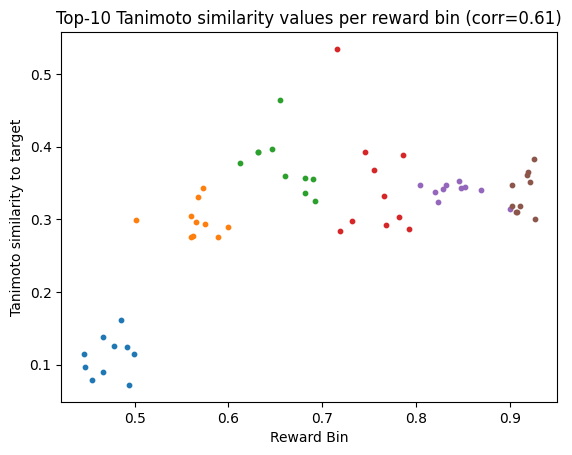

In [127]:
# bin samples by reward in intervals of "interval" where reward can be in [0, 1] range
interval = 0.1
reward_bins = np.arange(0, 1.1, interval)
reward_bin_idx = np.digitize(rewards, reward_bins)
reward_bin_idx = np.clip(reward_bin_idx, 1, len(reward_bins)-1)
reward_bin_idx -= 1

print("Number of samples per bin:")
for i in range(len(reward_bins)-1):
    print(f"Bin {i}: {np.sum(reward_bin_idx == i)}")

# find the top-k tanimoto similarity values per bin
k = 10
selected_samples = []
top_k_tan_sims_per_bin = {}
for i in range(len(reward_bins)-1):
    bin_idx = np.where(reward_bin_idx == i)[0]
    if len(bin_idx) == 0: continue
    tan_sims_in_bin = tanimoto_sims[bin_idx]
    top_k_idx = np.argsort(tan_sims_in_bin[:500])[::-1][:k]
    top_k_tan_sims_per_bin[i] = bin_idx[top_k_idx]
    selected_samples.extend([(rewards[j], tanimoto_sims[j]) for j in bin_idx[top_k_idx]])

# compute correlation coeff with selected samples
selected_rewards = [x[0] for x in selected_samples]
selected_tan_sims = [x[1] for x in selected_samples]
corr = np.corrcoef(selected_rewards, selected_tan_sims)[0, 1]

# plot the top-k tanimoto similarity values per bin
fig, ax = plt.subplots()
for i in range(len(reward_bins)-1):
    if i not in top_k_tan_sims_per_bin: continue
    bin_idx = top_k_tan_sims_per_bin[i]
    ax.scatter(rewards[bin_idx], tanimoto_sims[bin_idx], alpha=1, s=10, label=f"Bin {i}")

ax.set_xlabel("Reward Bin")
ax.set_ylabel("Tanimoto similarity to target")
ax.set_title(f"Top-{k} Tanimoto similarity values per reward bin (corr={corr:.2f})")
plt.show()

### Plot Top-K Assay Activity Logits per Binned Reward 

In [131]:
# First, we need to obtain logit predictions for the entire dataset which will 
# take some time to run
logit_values = predict_assay_logits_from_smi(smis, assay_model, target_active_assay_cols)
logit_values = np.concatenate([logit_values, random_assay_logits])
logit_values.shape

  0%|          | 0/313 [00:00<?, ?it/s]

100%|██████████| 313/313 [06:51<00:00,  1.31s/it]

(640000,)


(670000,)

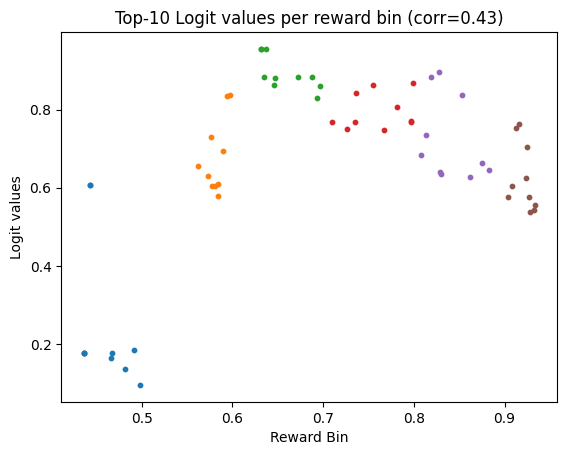

In [135]:
# Plot the top-k logit values per reward bin, same as above but replacing tanimoto sim for logit
k = 10
selected_samples = []
top_k_logit_values_per_bin = {}
for i in range(len(reward_bins)-1):
    bin_idx = np.where(reward_bin_idx == i)[0]
    if len(bin_idx) == 0: continue
    logit_values_in_bin = logit_values[bin_idx]
    top_k_idx = np.argsort(logit_values_in_bin[:5000])[::-1][:k]
    top_k_logit_values_per_bin[i] = bin_idx[top_k_idx]
    selected_samples.extend([(rewards[j], logit_values[j]) for j in bin_idx[top_k_idx]])

# compute correlation coeff with selected samples
selected_rewards = [x[0] for x in selected_samples]
selected_logit_values = [x[1] for x in selected_samples]
corr = np.corrcoef(selected_rewards, selected_logit_values)[0, 1]

# plot the top-k logit values per bin
fig, ax = plt.subplots()
for i in range(len(reward_bins)-1):
    if i not in top_k_logit_values_per_bin: continue
    bin_idx = top_k_logit_values_per_bin[i]
    ax.scatter(rewards[bin_idx], logit_values[bin_idx], alpha=1, s=10, label=f"Bin {i}")

ax.set_xlabel("Reward Bin")
ax.set_ylabel("Logit values")
ax.set_title(f"Top-{k} Logit values per reward bin (corr={corr:.2f})")
plt.show()

### Plot histogram of assay activity of top gflownet samples by reward

In [ ]:
# Plots a histogram of the top-k highest logit values among all molecules sampled by each method
active_cols = target_active_assay_cols.tolist() if isinstance(target_active_assay_cols, torch.Tensor) else target_active_assay_cols
fig, ax = plt.subplots(1, len(active_cols), figsize=(5*len(active_cols), 5), squeeze=False)

for model_name, smi in smis.items():
    if len(smi) < k or model_name in ["Target"]:
        continue
    # create a test dataset using the smiles and run inference with assay model
    full_df = pd.DataFrame(smi, columns=["smiles"])
    dataset = TestDataset(full_df, mol_col="smiles", label_col=None)
    dataloader = make_eval_data_loader(dataset, batch_size=128)
    y_hat = []
    for batch in tqdm(dataloader):
        y_hat.append(assay_model(batch)[0].detach().cpu().numpy())
    y_hat = np.vstack(y_hat)
    logit_values = y_hat[:, active_cols]
    # for each active column, we produce a separate hist plot of the logit values
    for i, col in enumerate(active_cols):
        # keep the top-k highest logit values in the current active column
        values = np.sort(logit_values[:, i])[::-1][:k]
        print(np.max(values), np.min(values))
        ax[0,i].hist(values, bins=50, label=model_name, alpha=0.4, density=True)

for i, col in enumerate(active_cols):
    ax[0,i].legend()
    ax[0,i].set_xlabel("Logit Value")
    ax[0,i].set_ylabel("Density")
    ax[0,i].set_title(f"Top-k Logit Values for assay {col}")

plt.show()

## Plot correlation between gflownet reward and target alignment

Target struct~morph alignment:  0.5116119


91703it [00:00, 458477.18it/s]

640000it [00:01, 504907.63it/s]
100%|██████████| 640000/640000 [00:11<00:00, 55875.33it/s]


0.39918533604887985


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Target struct~morph alignment:  0.8091375


640000it [00:01, 505832.43it/s]
100%|██████████| 640000/640000 [00:10<00:00, 58671.46it/s]


0.5345345345345346


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Target struct~morph alignment:  0.7213545


640000it [00:01, 458708.30it/s]
100%|██████████| 640000/640000 [00:11<00:00, 56058.31it/s]


0.4054621848739496


100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Target struct~morph alignment:  0.14777172


640000it [00:01, 508889.81it/s]
100%|██████████| 640000/640000 [00:10<00:00, 59178.58it/s]


0.3710691823899371


100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Target struct~morph alignment:  0.37507135


640000it [00:01, 492756.22it/s]
100%|██████████| 640000/640000 [00:10<00:00, 58219.59it/s]


0.35877862595419846


100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Target struct~morph alignment:  0.5820285


640000it [00:01, 506204.15it/s]
100%|██████████| 640000/640000 [00:11<00:00, 55909.90it/s]


0.46174863387978143


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Target struct~morph alignment:  0.074719705


640000it [00:01, 429492.19it/s]
100%|██████████| 640000/640000 [00:11<00:00, 56057.81it/s]


0.4107981220657277


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Target struct~morph alignment:  0.28096998


640000it [00:01, 507736.68it/s]
100%|██████████| 640000/640000 [00:10<00:00, 58962.12it/s]


0.5179856115107914


100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


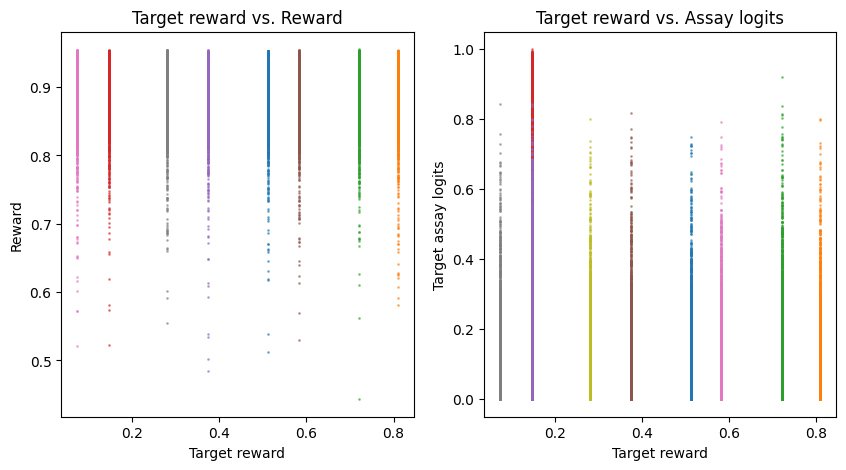

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

target_idx = [6888, 903, 2288, 10075, 1847, 8838, 13905, 39]
for target_id in target_idx:
    target_fp = dataset_fps[target_id]
    target_smi = datamodule.dataset[target_id]["inputs"]["struct"].mols.decode("utf-8")
    target_struct_latent = representations['struct'][target_id]
    target_morph_latent = representations['morph'][target_id]
    target_active_assay_cols = get_active_assay_cols(assay_dataset, target_smi)
    target_reward = cosine_similarity(target_struct_latent.reshape(1, -1), target_morph_latent.reshape(1, -1))[0][0]
    print(f"Target struct~morph alignment: ", target_reward)
    fps, rewards, smis = get_data_from_run(base_dir, run_id, target_fp)

    rnd_idx = np.random.choice(len(smis), 10000, replace=False)
    fps = [fps[i] for i in rnd_idx]
    rewards = [rewards[i] for i in rnd_idx]
    smis = [smis[i] for i in rnd_idx]

    full_df = pd.DataFrame(smis, columns=["smiles"])
    dataset = TestDataset(full_df, mol_col="smiles", label_col=None)
    dataloader = make_eval_data_loader(dataset, batch_size=2048)
    y_hat = []
    for batch in tqdm(dataloader):
        y_hat.append(assay_model(batch)[0].detach().cpu().numpy())
    y_hat = np.vstack(y_hat)
    logit_values = y_hat[:, target_active_assay_cols.tolist()]

    for i, col in enumerate(target_active_assay_cols):
        ax[1].scatter([target_reward]*len(rewards), logit_values[:, i], alpha=0.5, s=1)
    
    # scatter plot target reward versus rewards
    ax[0].scatter([target_reward]*len(rewards), rewards, alpha=0.5, s=1)

ax[0].set_xlabel("Target reward")
ax[0].set_ylabel("Reward")
ax[0].set_title("Target reward vs. Reward")

ax[1].set_xlabel("Target reward")
ax[1].set_ylabel("Target assay logits")
ax[1].set_title("Target reward vs. Assay logits")

plt.show()